In [297]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
import datetime as dt
import matplotlib.dates as mdates
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, r2_score

In [298]:
from keras.models import Sequential
from keras.layers import Dropout, Dense
from sklearn.utils import shuffle
import sys
import talos

In [299]:
# Changes the font parameters for the charts
params = {'legend.fontsize': 14,
         'axes.labelsize': 16,
         'axes.titlesize': 16,
         'xtick.labelsize': 10,
         'ytick.labelsize': 10}
plt.rcParams.update(params)

In [300]:
params = {}

In [301]:
## Change to the 'Datasets directory'
initial_dir = os.getcwd()
data_path = os.path.join(os.getcwd(), "data")

In [335]:
## Import the train and test dataframes. Drop the 'dateRep' column as it is not need for the prediciton.
train_X = pd.read_csv(os.path.join(data_path, "train", 'train_x.csv'), index_col=0).sample(frac=1, random_state=1)
train_y = pd.read_csv(os.path.join(data_path, "train", 'train_y.csv'), index_col=0).sample(frac=1, random_state=1)
## '.sample' randomises the dataframe as the validation test below will take the bottom 20% of the data
## 'frac=1' means it will use all the data and 'random_state=1' keeps the resample consistent between df's
test_x = pd.read_csv(os.path.join(data_path, "test", 'test_x.csv'), index_col=0).sample(frac=1, random_state=1)
test_y = pd.read_csv(os.path.join(data_path, "test", 'test_y.csv'), index_col=0).sample(frac=1, random_state=1)

In [336]:
## Initialise Scalars so that data is normalised to 1.
sc_x = StandardScaler()
sc_y = StandardScaler()
## Normalise the data using the scalar.
X_train = sc_x.fit_transform(train_X)
X_test = sc_x.transform(test_x)

y_train = sc_y.fit_transform(train_y)
y_test = sc_y.transform(test_y)

In [337]:
## Calculate the number of input 'test' columns.
input_neuron = len(test_x.columns)
input_neuron

6

In [338]:
# then we can go ahead and set the parameter space
p = {'first_neuron':[4, 8, 16, 32, 64],
     'hidden_layers':[0, 1, 2],
     'batch_size': [16, 32, 64, 128],
     'epochs': [150],
     'optimizer': ['Nadam', 'Adam', 'SGD', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax'],
     'losses': ['mean_squared_error'],
     'activation':['relu', 'elu'],
     'last_activation': ['sigmoid']}

In [339]:
## Setup the model for training, parameters here can and should be adjusted to create the best model.
classifier = Sequential()
classifier.add(Dense(output_dim = 18, init = 'uniform', activation = 'relu', input_dim = input_neuron))
classifier.add(Dense(output_dim = 6, init = 'uniform', activation = 'relu'))
classifier.add(Dense(output_dim = 1, init = 'uniform', activation = 'linear'))

classifier.compile(optimizer = 'SGD', loss = 'mean_squared_error', metrics = ["mae"])
## '.fit' starts the training. 30 seconds to 2 minutes to run.
classifier.fit(X_train, y_train, batch_size = 32, nb_epoch = 1000, validation_split= 0.2)


Train on 480 samples, validate on 120 samples
Epoch 1/1000
480/480 [==============================] - 0s 877us/step - loss: 1.0160 - mae: 0.7911 - val_loss: 0.9381 - val_mae: 0.7704
Epoch 2/1000
480/480 [==============================] - 0s 43us/step - loss: 1.0165 - mae: 0.7899 - val_loss: 0.9381 - val_mae: 0.7703
Epoch 3/1000
480/480 [==============================] - 0s 42us/step - loss: 1.0162 - mae: 0.7896 - val_loss: 0.9380 - val_mae: 0.7703
Epoch 4/1000
480/480 [==============================] - 0s 43us/step - loss: 1.0161 - mae: 0.7896 - val_loss: 0.9380 - val_mae: 0.7703
Epoch 5/1000
480/480 [==============================] - 0s 41us/step - loss: 1.0159 - mae: 0.7883 - val_loss: 0.9379 - val_mae: 0.7706
Epoch 6/1000
480/480 [==============================] - 0s 40us/step - loss: 1.0157 - mae: 0.7902 - val_loss: 0.9378 - val_mae: 0.7704
Epoch 7/1000
480/480 [==============================] - 0s 39us/step - loss: 1.0157 - mae: 0.7901 - val_loss: 0.9377 - val_mae: 0.7701
Epoch 8/

In [340]:
model_path = os.path.join(os.getcwd(), "model")
# Check if the relevant folders exist and create them if not
if os.path.exists(model_path) is False:
    os.mkdir(model_path)
# Export the model for future use to that you don't need to spend time training the model again
pickle.dump(classifier, open(os.path.join(model_path, "ReinNN.pkl"), "wb"))

In [341]:
"""model_path = os.path.join(data_folder, "model")
# Import the exported model in future runs using the greyed out line below (remove the hastag)
model = pickle.load(open(os.path.join(model_path, "ReinNN.pkl"), "rb"))"""

'model_path = os.path.join(data_folder, "model")\n# Import the exported model in future runs using the greyed out line below (remove the hastag)\nmodel = pickle.load(open(os.path.join(model_path, "ReinNN.pkl"), "rb"))'

In [342]:
# Calculate the predicted deaths according to the neural net model
test_x["gold_pred"] = sc_y.inverse_transform(classifier.predict(X_test))
# Calculate the predicted deaths according to the neural net model
train_X["gold_pred"] = sc_y.inverse_transform(classifier.predict(X_train))
#df1 = pd.concat([test_x, train_X], axis=1)
df= train_X.merge(train_y,left_index=True, right_index=True)
# We merge the test dataframes together
df1 = test_x.merge(test_y, left_index=True, right_index=True)
# We append the test data to the train data
df = df.append(df1)

In [343]:
gold_col = 'GOLDAMGBDollarD228NLBM' # 'GOLD_shift' 

In [344]:
# Again read in the 'covid19_df' as df_global
df_global = pd.read_csv(os.path.join(os.getcwd(), "Data_Export", "gold_df.csv"), index_col=0)
# Merge in the 'deaths_pred' prediction column to compare to the real data
df_global = df_global.merge(df["gold_pred"], left_index=True, right_index=True, how='left')

In [345]:
"""idx = pd.date_range(start=dt.date(2020, 9, 30), end=dt.date(2022, 8, 31), freq='M')

df_global1 = df_global.copy().reindex(idx)
df_global = df_global.append(df_global1).reset_index()

df_global['index'] = pd.to_datetime(df_global['index'])
df_global.index = df_global['index']
df_global.drop(['index'], axis=1, inplace=True)

#df_global.tail(40)"""

"idx = pd.date_range(start=dt.date(2020, 9, 30), end=dt.date(2022, 8, 31), freq='M')\n\ndf_global1 = df_global.copy().reindex(idx)\ndf_global = df_global.append(df_global1).reset_index()\n\ndf_global['index'] = pd.to_datetime(df_global['index'])\ndf_global.index = df_global['index']\ndf_global.drop(['index'], axis=1, inplace=True)\n\n#df_global.tail(40)"

No handles with labels found to put in legend.


Text(0, 0.5, 'Price (US $)')

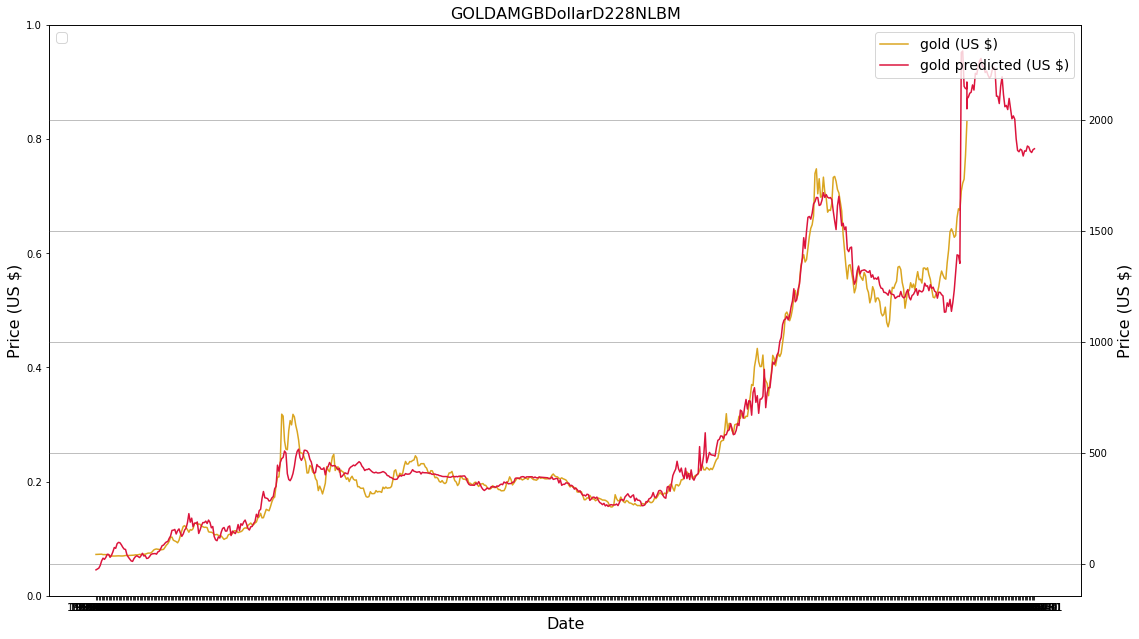

In [346]:
# Visualising the Linear Regression results.
fig, ax1 = plt.subplots()
j = 'GOLDAMGBDollarD228NLBM'
k = 'gold_pred_error'
l = 'gold_pred'

#ax1.plot(df_global.index, df_global[k], label=k, c='mediumturquoise')
#plt.axvline(x=dt.date(2019, 1, 1), linestyle='--', color='red', label='Data_merge')


ax2 = ax1.twinx()
ax2.plot(df_global.index, df_global[j], label='gold (US $)', c='goldenrod')
ax2.plot(df_global.index, df_global[l], label='gold predicted (US $)', c='crimson')

#ax1.ylim(0, 15)
plt.title(j)
plt.xlabel('Date')
plt.grid()
ax1.legend(loc=2)
ax2.legend(loc=1)
fig.set_size_inches(18.5, 10.5)

ax1.set_xlabel('Date')
ax1.set_ylabel('Price (US $)')
ax2.set_ylabel('Price (US $)')
#plt.savefig('cumulative_error_20_countries_XGB_dpi300.jpeg', dpi=300)

In [315]:
# if we are creating a shifted gold column
#df_global['gold_pred_shift'] = df_global['gold_pred']
df_global['gold_pred'] = df_global['gold_pred'].shift(periods=24, fill_value=0)

In [316]:
# Compute the prediction error
df_global['gold_pred_error'] = df_global['GOLDAMGBDollarD228NLBM'] - df_global['gold_pred']
# Compute the cumulative error for each country individually
df_global['cumulative_error'] = df_global['gold_pred_error'].cumsum()

In [318]:
## Calculate the mean absolute error and R2 scores for the predicted vs real data.
#print(f"DL MAE score: {np.round(mean_absolute_error(df[gold_col], df.gold_pred))}")
#print(f"DL R2 score: {np.round(r2_score(df[gold_col], df.gold_pred), 4)}")

Text(0, 0.5, 'Price (US $)')

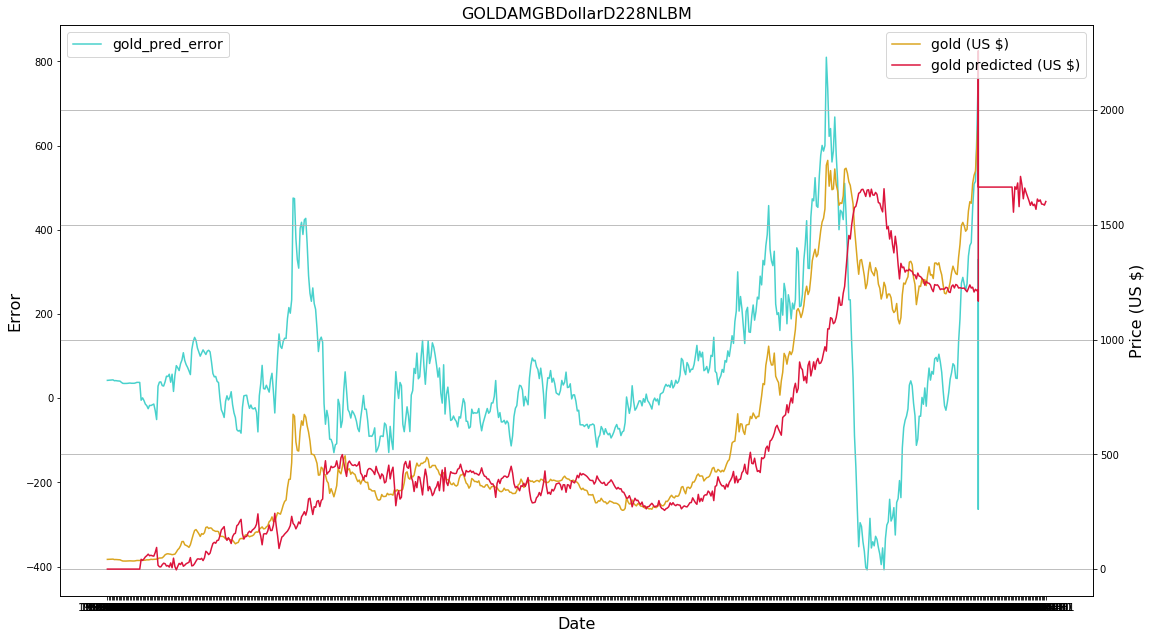

In [319]:
# Visualising the Linear Regression results.
fig, ax1 = plt.subplots()
j = 'GOLDAMGBDollarD228NLBM'
k = 'gold_pred_error'
l = 'gold_pred'

ax1.plot(df_global.index, df_global[k], label=k, c='mediumturquoise')


ax2 = ax1.twinx()
ax2.plot(df_global.index, df_global[j], label='gold (US $)', c='goldenrod')
ax2.plot(df_global.index, df_global[l], label='gold predicted (US $)', c='crimson')

#ax1.ylim(0, 15)
plt.title(j)
plt.xlabel('Date')
plt.grid()
ax1.legend(loc=2)
ax2.legend(loc=1)
fig.set_size_inches(18.5, 10.5)

ax1.set_xlabel('Date')
ax1.set_ylabel('Error')
ax2.set_ylabel('Price (US $)')
#plt.savefig('cumulative_error_20_countries_XGB_dpi300.jpeg', dpi=300)

Text(0, 0.5, 'Price (US $)')

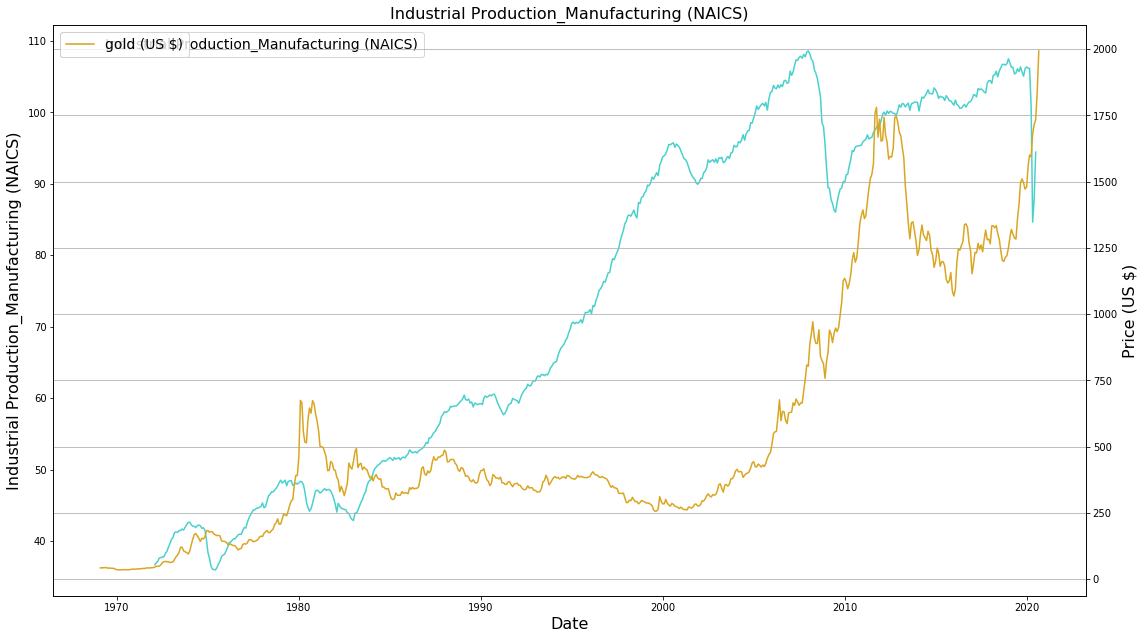

In [73]:
# Visualising the Linear Regression results.
fig, ax1 = plt.subplots()
j = 'Industrial Production_Manufacturing (NAICS)'

ax1.plot(df_global.index, df_global[j], label=j, c='mediumturquoise')

ax2 = ax1.twinx()
ax2.plot(df_global.index, df_global['GOLDAMGBDollarD228NLBM'], label='gold (US $)', c='goldenrod')

#ax1.ylim(0, 15)
plt.title(j)
plt.xlabel('Date')
plt.grid()
ax1.legend(loc=2)
ax2.legend()
fig.set_size_inches(18.5, 10.5)

#years = mdates.YearLocator()   # every year
#ax1.xaxis.set_major_locator(years)
#years_fmt = mdates.DateFormatter('%Y')
#months = mdates.MonthLocator()  # every month
#ax1.xaxis.set_major_formatter(years_fmt)
#ax1.xaxis.set_minor_locator(months)

#ax1.set_xlim([datetime.date(2008, 1, 26), datetime.date(2021, 1, 1)])
ax1.set_xlabel('Date')
ax1.set_ylabel(j)
ax2.set_ylabel('Price (US $)')

In [118]:
## Check for the directory and output the df_global dataframe.
if os.path.exists(os.path.join(os.getcwd(), "model_predictions")) is False:
    os.mkdir(os.path.join(os.getcwd(), "model_predictions"))
df_global.to_csv(os.path.join(os.getcwd(), "model_predictions", "Rein_nn_predictions.csv"))

In [119]:
#plt.style.use("ggplot")

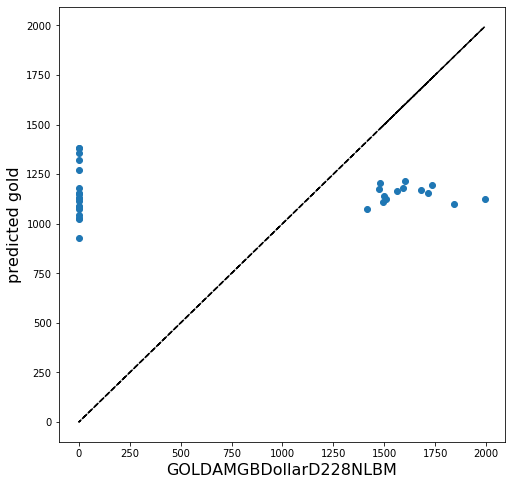

In [120]:
## Plot deaths vs predicted.
plt.figure(figsize=(8, 8))
plt.scatter(df.GOLDAMGBDollarD228NLBM, df.gold_pred)
plt.plot(df.GOLDAMGBDollarD228NLBM, df.GOLDAMGBDollarD228NLBM, color="black", linestyle="--")
plt.xlabel("GOLDAMGBDollarD228NLBM")
plt.ylabel("predicted gold")
plt.show()